### FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.motifs import pYmotifs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [56]:
PsP = pd.read_csv("./msresist/data/Sequence_analysis/pX_dataset_PhosphoSitePlus2019.csv")
PsP.shape

(371203, 2)

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

In [3]:
from sklearn.model_selection import LeaveOneOut
import scipy as sp

def plotActualVsPredicted(ax, plsr_model, X, Y, cv, y_pred="cross-validation"):
    """ Plot exprimentally-measured vs PLSR-predicted values. """
    if y_pred == "cross-validation":
        cols = X.columns
        y_ = np.array(Y)
        X = np.array(X)
        Y_predictions = []
        if cv == 1:
            for train_index, test_index in LeaveOneOut().split(X, y_):
                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = y_[train_index], y_[test_index]
                Y_train = sp.stats.zscore(Y_train)
                plsr_model.fit(X_train, Y_train)
                Y_predict = list(plsr_model.predict(X_test).reshape(y_.shape[1],))
                Y_predictions.append(Y_predict)
        if cv == 2:
            for train_index, test_index in LeaveOneOut().split(X, y_):
                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = y_[train_index], y_[test_index]
                Y_train = sp.stats.zscore(Y_train)
                X_train = pd.DataFrame(X_train)
                X_train.columns = cols
                plsr_model.fit(pd.DataFrame(X_train), Y_train)
                Y_predict = list(plsr_model.predict(pd.DataFrame(X_test)).reshape(y_.shape[1],))
                Y_predictions.append(Y_predict)

        Y_predictions = np.array(Y_predictions)
        ylabel = "Predicted"
    if y_pred == "fit":
        Y_predictions = plsr_model.fit(X, Y).predict(X)
        ylabel = "Fit"

    y = Y.iloc[:, 0]
    ypred = Y_predictions[:, 0]
    ax.scatter(y, ypred)
    ax.plot(np.unique(y), np.poly1d(np.polyfit(y, ypred, 1))(np.unique(y)), color="r")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

    spacer = 1.1

    # Add correlation coefficient
    coeff, _ = sp.stats.pearsonr(ypred, y)
    textstr = "$r$ = " + str(np.round(coeff, 4))
    props = dict(boxstyle='square', facecolor='none', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [4]:
X = preprocessing(AXLwt=True, Vfilter=False, FCfilter=False, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

treatments = d.index


0/1493 peptides were not found in the proteome.
1493


In [57]:
X[X["Gene"].str.contains("PIK3R2")]

,Protein,Sequence,UniprotAcc,Position,Gene,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
575,Phosphatidylinositol 3-kinase regulatory subun...,DKsREyDQLYE,O00459,Y460-p;S457-p,PIK3R2,0.401300,0.338684,0.428207,-0.160893,0.620140,0.092821,-0.041866,-0.537542,-0.255348,-0.885503
576,Phosphatidylinositol 3-kinase regulatory subun...,ETEDQyALMED,O00459,Y605-p,PIK3R2,0.702668,0.140361,0.322088,-0.286313,0.162196,-0.147398,-0.198212,-0.678798,0.028216,-0.044807
577,Phosphatidylinositol 3-kinase regulatory subun...,EYDQLyEEYTR,O00459,Y464-p,PIK3R2,0.381704,0.103463,0.248136,-0.342258,0.453243,0.049739,-0.012388,-0.372166,-0.011820,-0.497652


### Phenotypes

#### Cell Viability:

In [5]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw4.csv').iloc[:29, :11]

itp = 0
ftp = 72


for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[itp, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[itp, ii]

y_ = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
y_ = y_.reset_index()[Y_cv1.columns]
y = pd.DataFrame()
y["Cell Viability"] = y_[y_["Elapsed"] == ftp].iloc[0, 1:]

In [6]:
from scipy.stats import zscore
y.iloc[:, :] = zscore(y.iloc[:, :])
y

,Cell Viability
PC9,2.208011
E,-0.362599
R,-0.262451
ER,-0.981351
EHGF,0.506524
EFGF,1.306331
EIGF,-0.113511
KOE,-0.790817
KOR,-0.423649
KOER,-1.086487


# 1-.Fitting PLSR model to the full data set

#### R2Y/Q2Y

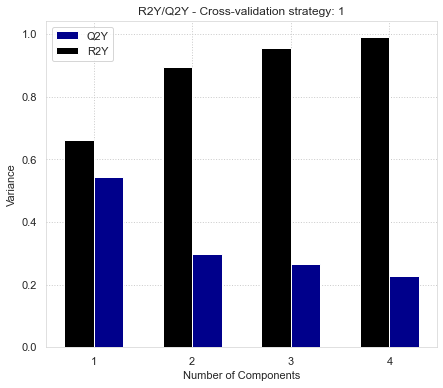

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p1 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax, p1, d, y, 1, 5)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

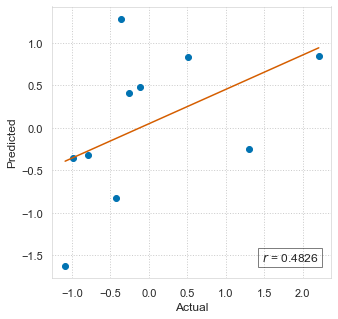

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p1, d, y, cv=1, y_pred="cross-validation")

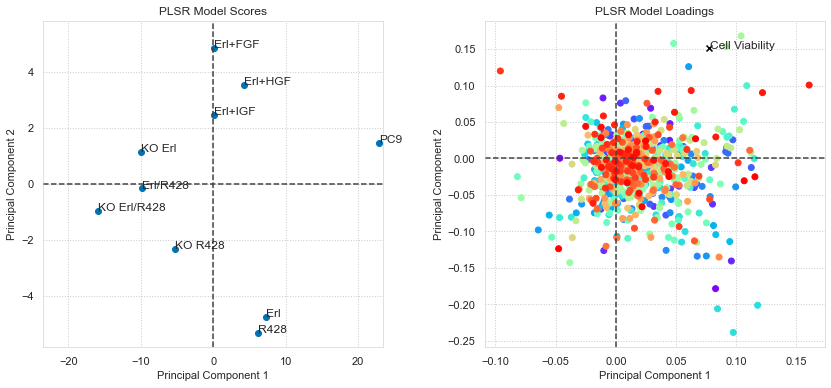

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p1.fit(d, y), d, y, 0, treatments, cv=1, data="full", annotate=False)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

# 2-Clustering and PLSR model

In [10]:
ncl = 9

## 2.1-Standard Clustering methods + PLSR

#### k-means:

In [11]:
# from sklearn.cluster import KMeans

# labels = KMeans(n_clusters=ncl).fit(d.T).labels_
# x_ = X.copy()
# x_["Cluster"] = labels
# c1 = x_.groupby("Cluster").mean().T

#### SKLEARN's GMM:

In [12]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=ncl).fit(d.T)
x_ = X.copy()
x_["Cluster"] = gmm.predict(d.T)
c1 = x_.groupby("Cluster").mean().T

In [13]:
w = x_[x_["Cluster"] == 5].iloc[:, 5:-1]

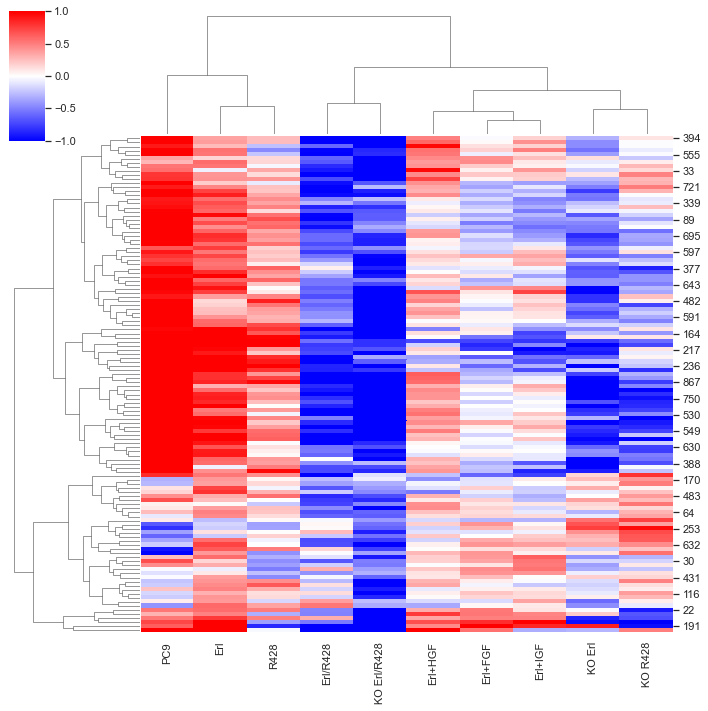

In [14]:
from msresist.figures.figure1 import plotClustergram
plotClustergram(w, " ", lim=1)
plt.savefig("heatmap.svg", bbox_inches='tight', format='svg', dpi=1200)

#### POMEGRANATE's GMM:

In [15]:
# from pomegranate import GeneralMixtureModel, NormalDistribution

# gmm = GeneralMixtureModel.from_samples(NormalDistribution, X=d.T, n_components=ncl, n_jobs=-1)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### R2Y/Q2Y

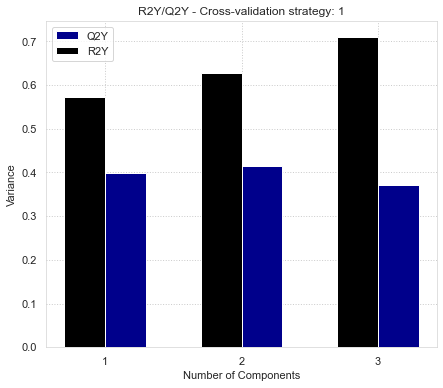

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p2 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax, p2, c1, y, 1, 4)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

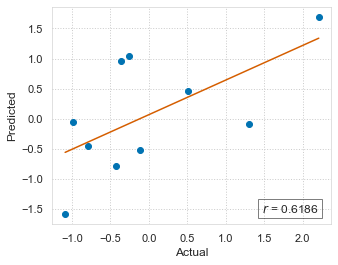

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p2, c1, y, cv=1, y_pred="cross-validation")

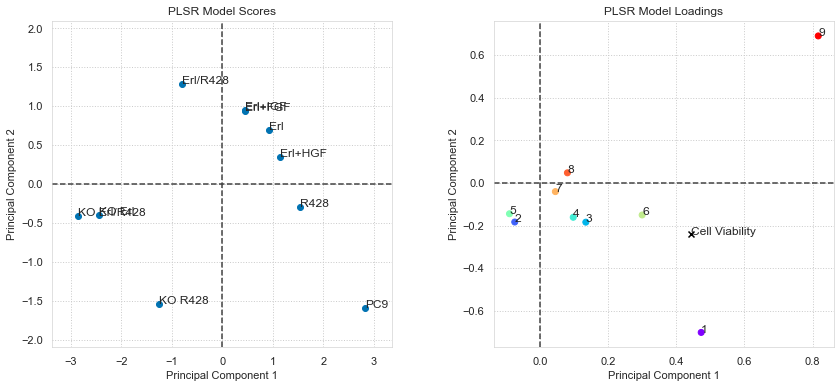

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p2.fit(c1, y), c1, y, ncl, treatments, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.2-Co-clustering and PLSR

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

### Fitting PLSR each time

In [19]:
distance_method = "PAM250"
ncl = 15
SeqWeight = 10000

MSC = MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method, gmm_method="sklearn", n_runs=3).fit(d, y)
c2 = MSC.transform(d)

15 10000
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 2
Re-initialize GMM clusters, empty cluster(s) at iteration 3
Re-initialize GMM clusters, empty cluster(s) at iteration 4
Re-initialize GMM clusters, empty cluster(s) at iteration 5
Re-initialize GMM clusters, empty cluster(s) at iteration 6
Re-initialize GMM clusters, empty cluster(s) at iteration 7
Re-initialize GMM clusters, empty cluster(s) at iteration 8
Re-initialize GMM clusters, empty cluster(s) at iteration 9
Re-initialize GMM clusters, empty cluster(s) at iteration 10
Re-initialize GMM clusters, empty cluster(s) at iteration 11
Re-initialize GMM clusters, empty cluster(s) at iteration 12
Re-initialize GMM clusters, empty cluster(s) at iteration 13
Re-initialize GMM clusters, empty cluster(s) at iteration 14
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters

In [21]:
x_ = X.copy()
x_["Cluster"] = MSC.labels_

In [23]:
for i in range(15):
    print(len(x_[x_["Cluster"] == i]["Sequence"]))

62
98
77
43
56
87
60
27
51
23
63
20
66
114
24


#### R2Y/Q2Y

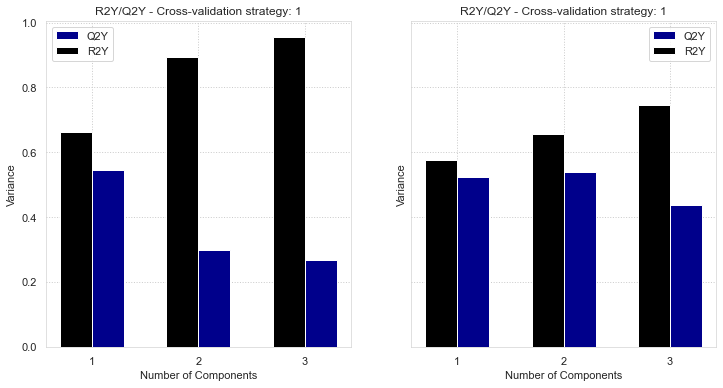

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plotR2YQ2Y(ax[0], p1, d, y, 1, 4)

p3 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax[1], p3, c2, y, 1, 4)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

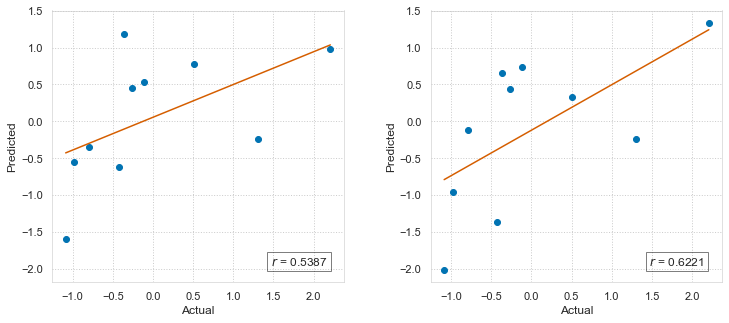

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(axes[0], p1, d, y, cv=1, y_pred="cross-validation")
plotActualVsPredicted(axes[1], p3, c2, y, 1, y_pred="cross-validation")
axes[1].yaxis.set_tick_params(labelleft=True)
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

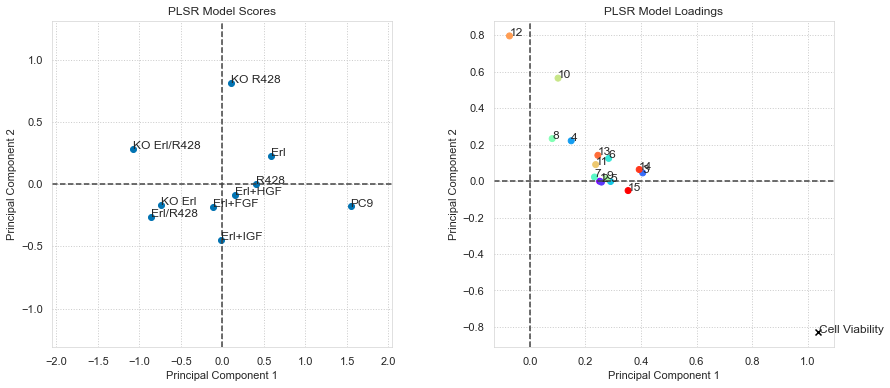

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, treatments, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.3-Random clustering and PLSR

In [ ]:
from random import choices
x__ = X.copy()
x__["Cluster"] = choices(list(np.arange(ncl)), k=X.shape[0])
c3 = x__.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p4 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p4, c3, y, 1, ncl+1)

#### Predictions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p4, c3, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [ ]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp, scale=False))])
fit = CoCl_plsr.fit(d, y.values)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

#### R2Y/Q2Y

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=5)

#### GridSearch

Run:

In [ ]:
%%time
scores = MSclusPLSR_tuning(d, i, y, "PAM250")
scores = pd.DataFrame(scores)

In [ ]:
hp = scores.sort_values(by="mean_test_score", ascending=False)
hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
plotActualVsPredicted(ax, CoCl_plsr, d, y, 2)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, lines, 2)

In [ ]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")